# Imports

Import libraries to load CSV data, plot graphs, and create the machine learning model and algorithm.

In [23]:
import csv
import numpy as np
import matplotlib.pyplot as mpl
import random
import tensorflow as tf
import ipywidgets as widgets

# Load data set

The data set is a CSV file of emails and ham/spam labels downloaded from Kaggle.

In [6]:
class EmailDataSet():
    raw_training_data = None
    raw_testing_data = None
    tensor_training_data = None
    tensor_testing_data = None
    training_emails = None
    training_labels = None
    testing_emails = None
    testing_labels = None
    

email_data_set = EmailDataSet()

def load_data():
    ham_email_data = [] 
    spam_email_data = []

    with open("./emails.csv") as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)
        for row in reader:
            spam_label = row[1]
            if spam_label == "1":
                row[1] = True
                spam_email_data.append(row)
            else:
                row[1] = False
                ham_email_data.append(row)
            
    # use 80% for training and 20% for testing
    # evenly distribute ham and spam
    ham_split = round(0.8 * len(ham_email_data))
    spam_split = round(0.8 * len(spam_email_data))

    email_data_set.raw_training_data = ham_email_data[:ham_split] + spam_email_data[:spam_split]
    email_data_set.raw_testing_data = ham_email_data[ham_split:] + spam_email_data[spam_split:]

    # randomize so that ham isn't all in the start and spam isn't all in the end
    random.shuffle(email_data_set.raw_training_data)
    random.shuffle(email_data_set.raw_testing_data)

load_data()

# Visualize split of ham/spam emails

This chart is a descriptive method that visualizes how the data set is distributed into different sub-categories. The ham/spam ratio is intentionally the same for both the training and testing sets.

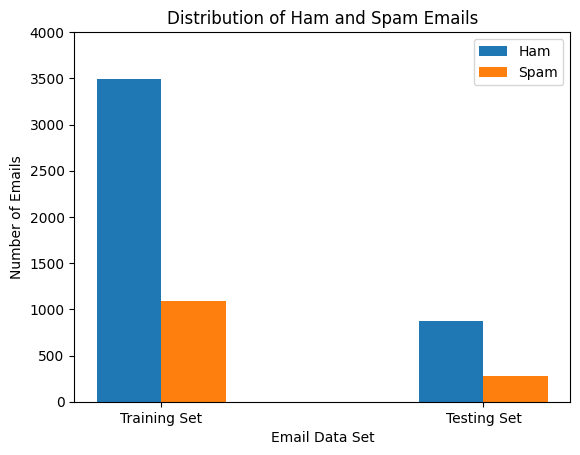

In [14]:
def display_ham_spam_bar_chart(data_object):
    training_ham = 0
    training_spam = 0
    testing_ham = 0
    testing_spam = 0
    for entry in data_object.raw_training_data:
        if entry[1]:
            training_spam += 1
        else:
            training_ham += 1
    for entry in data_object.raw_testing_data:
        if entry[1]:
            testing_spam += 1
        else:
            testing_ham += 1

    X = ["Training Set", "Testing Set"]
    Yham = [training_ham, testing_ham]
    Zspam = [training_spam, testing_spam]

    X_axis = np.arange(len(X))
    Y_axis = np.arange(4500)

    mpl.bar(X_axis - 0.1, Yham, 0.2)
    mpl.bar(X_axis + 0.1, Zspam, 0.2)

    mpl.xticks(X_axis, X)
    mpl.yticks(np.arange(Y_axis.min(), Y_axis.max(), 500), [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
    mpl.xlabel("Email Data Set")
    mpl.ylabel("Number of Emails")
    mpl.title("Distribution of Ham and Spam Emails")
    mpl.legend(["Ham", "Spam"])
    mpl.show()

display_ham_spam_bar_chart(email_data_set)

# Pre-Process Email Data

The data set will be used in different contexts that expect the data to be in specific shapes. To prevent repetition of data transformations, we will process the date here.

In [15]:
def pre_process_data(data_object: EmailDataSet):
    # Extract data from the email and label columns for the split of training/testing data
    data_object.training_emails = [data[0] for data in data_object.raw_training_data]
    data_object.training_labels = [data[1] for data in data_object.raw_training_data]
    data_object.testing_emails = [data[0] for data in data_object.raw_testing_data]
    data_object.testing_labels = [data[1] for data in data_object.raw_testing_data]

    # Convert to tensors
    training_text_tensor = tf.constant(data_object.training_emails)
    training_label_tensor = tf.constant(data_object.training_labels)
    testing_text_tensor = tf.constant(data_object.testing_emails)
    testing_label_tensor = tf.constant(data_object.testing_labels)

    # Reshape tensors
    training_text_tensor = tf.reshape(training_text_tensor, (training_text_tensor.shape[0],1))
    training_label_tensor = tf.reshape(training_label_tensor, (training_label_tensor.shape[0],1))
    testing_text_tensor = tf.reshape(testing_text_tensor, (testing_text_tensor.shape[0],1))
    testing_label_tensor = tf.reshape(testing_label_tensor, (testing_label_tensor.shape[0],1))

    # Create and batch data sets
    formatted_training_data = tf.data.Dataset.from_tensor_slices((training_text_tensor, training_label_tensor))
    formatted_testing_data = tf.data.Dataset.from_tensor_slices((testing_text_tensor, testing_label_tensor))
    formatted_training_data = formatted_training_data.batch(64)
    formatted_testing_data = formatted_testing_data.batch(64)

    data_object.tensor_training_data = formatted_training_data
    data_object.tensor_testing_data = formatted_testing_data
    
pre_process_data(email_data_set)

# Encode Text into Integer Tokens for NLP

This will enable to the model to process the email text as mathematical data. Note the `max_tokens` argument to prevent excessive training time.

In [16]:
def tokenize(data_object: EmailDataSet):
    # Create NLP vocabulary based on training emails
    encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=20000)
    vocab_data = data_object.training_emails
    encoder.adapt(vocab_data)

    return encoder

class Encoder():
    encoder = None

encoder_obj = Encoder()

encoder_obj.encoder = tokenize(email_data_set)

# Create Bi-directional Long Short Term Memory (Bi-LSTM) Algorithm Model

In [17]:
def create_model(encoder):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
          len(encoder.get_vocabulary()),
          64,
          mask_zero = True
        ),
        tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(
            64,
            return_sequences=True
          )
        ),
        tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(
            32,
          )
        ),
        tf.keras.layers.Dense(64, activation="sigmoid"),
        tf.keras.layers.Dense(1)
    ])

    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Nadam(),
        loss=tf.keras.losses.BinaryCrossentropy(
          from_logits=True
        ),
        metrics=["accuracy"],
        run_eagerly=True
    )

    return model

class Model():
    model = None

model_object = Model()

model_object.model = create_model(encoder_obj.encoder)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

# Load Model to Avoid Training Time

Run this to avoid having to wait for the model to train itself in the following code block.

In [23]:
def load_model(model_object: Model):
    model_object.model = tf.keras.models.load_model("spam_email.keras")

load_model(model_object)

# Train Model

The portion where the model actually learns from the data set. Due to the length of email text, this process is rather long.

In [18]:
def train_model(model, data_object: EmailDataSet):
    # Keep track of history to visualize in a chart
    training_history = {
       "loss_history": [],
        "accuracy_history": []
    }

    def record_history(logs):
      training_history["loss_history"].append(logs["loss"])
      training_history["accuracy_history"].append(logs["accuracy"])

    save_loss_accuracy = tf.keras.callbacks.LambdaCallback(
        on_batch_end= lambda _, logs: record_history(logs)
    )

    final_results = model.fit(
        data_object.tensor_training_data,
        validation_data=data_object.tensor_testing_data,
        callbacks=[
           save_loss_accuracy
        ]
    )

    # Save model to avoid having to train it every single time
    model.save("spam_email.keras")

    results = {
       "final_results": final_results,
       "training_history":training_history
    }

    return results

class TrainingResults():
   results = None

t_results_object = TrainingResults()

t_results_object.results = train_model(model_object.model, email_data_set)

72/72 [==============================] - 1402s 20s/step - loss: 0.2703 - accuracy: 0.8804 - val_loss: 0.0702 - val_accuracy: 0.9808


# Loss and Accuracy Over the Course of Training

This takes the training results and plots them on a line graph in a descriptive method. Note the increase in accuracy and decrease in loss as more training is conducted.

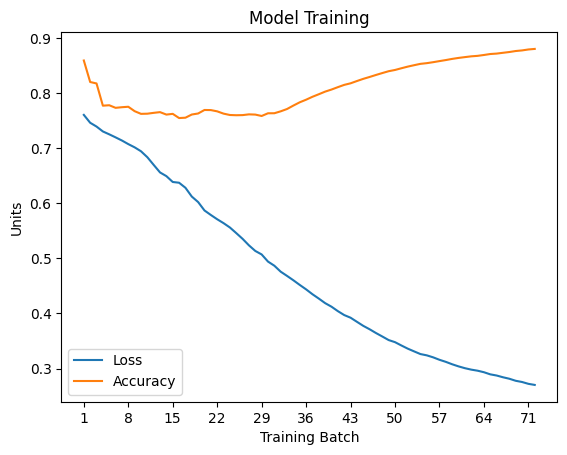

In [19]:
def visualize_training(training_results: TrainingResults):
  x_loss = np.arange(1, len(training_results.results["training_history"]["loss_history"]) + 1)
  x_accuracy = x_loss
  y_loss = np.array(training_results.results["training_history"]["loss_history"])
  y_accuracy = np.array(training_results.results["training_history"]["accuracy_history"])
  mpl.plot(x_loss,y_loss, label="Loss")
  mpl.plot(x_accuracy,y_accuracy, label="Accuracy")
  mpl.legend()
  mpl.xticks(range(1,len(training_results.results["training_history"]["loss_history"]) + 1, 7))
  mpl.xlabel("Training Batch")
  mpl.ylabel("Units")
  mpl.title("Model Training")
  mpl.show()

visualize_training(t_results_object)

# Model Assessment

This assesses the model by using the testing data to see how many correct guesses, false positives, and false negatives the model will generate. Then using those values, we can calculate the respective percentages.

In [20]:
def assess_model(model, data_object: EmailDataSet):
    testing_text = data_object.testing_emails
    testing_label = data_object.testing_labels
    assessment_data = model.predict(testing_text)

    correct = 0
    false_positive = 0
    false_negative = 0

    for i in range(len(assessment_data)):
        if testing_label[i] and assessment_data[i][0] <= 0:
            false_negative += 1
        elif not testing_label[i] and assessment_data[i][0] > 0:
            false_positive += 1
        else:
            correct += 1

    assessment_results = [correct, false_positive, false_negative]
    
    return assessment_results

class AssessmentResults():
    results = None

a_results_object = AssessmentResults()

assessment_results = assess_model(model_object.model, email_data_set)
a_results_object.results = assessment_results

36/36 [==============================] - 126s 3s/step


# Visualization of Assessment

This pie chart is a descriptive method to show the distribution of correct guesses, false positives, and false negatives from the model assessment.

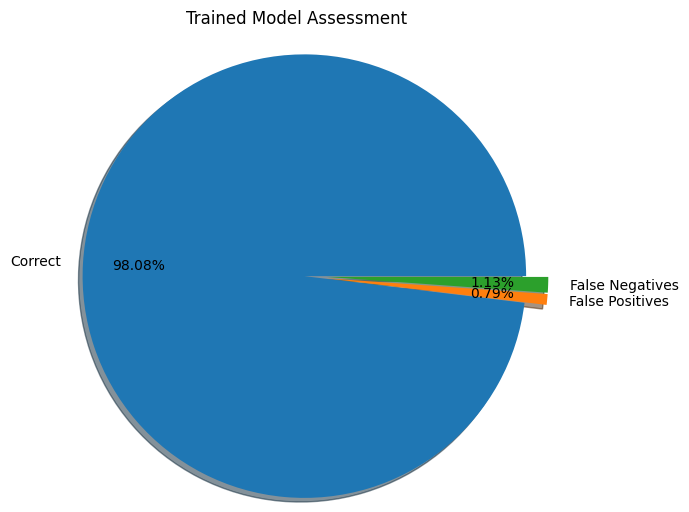

In [21]:
def visualize_assessment(assessment_results: AssessmentResults):
  labels = ["Correct", "False Positives", "False Negatives"]
  values = assessment_results.results

  fig, ax = mpl.subplots()
  fig.suptitle("Trained Model Assessment", y=1.05)
  ax.pie(values, labels=labels, radius=1.5, autopct="%1.2f%%", pctdistance=0.75, shadow=True, explode=(0, 0.15, 0.15))

visualize_assessment(a_results_object)

# Test the Model Yourself

Enter an email and have the model determine whether it is ham or spam. This is a nondescriptive method due to making a prediction.

In [40]:
class CustomInteractiveWidget():
  model_object = None
  email_counter = 1
  text_area = widgets.Textarea(placeholder="I am a foreign prince! Would you like free money?")
  submit_button=widgets.Button(description="Submit Email", button_style="primary")
  out = widgets.Output()

  def set_model(self, model):
     self.model_object = model

  def predict_ham_or_spam(self, _):
    results = model_object.model.predict([self.text_area.value])
    self.out.clear_output()
    with self.out:
       print(f"Email #{self.email_counter}:")
    if results[0] > 0:
      with self.out:
          print("That's spam!")
    else:
      with self.out:
          print("That's ham!")
    self.email_counter += 1
    self.text_area.value = ""

  def display_widget(self):
    display(self.text_area, self.submit_button, self.out)
    self.submit_button.on_click(self.predict_ham_or_spam)

interactive_widget = CustomInteractiveWidget()
interactive_widget.set_model(model_object)
interactive_widget.display_widget()

Textarea(value='', placeholder='I am a foreign prince! Would you like free money?')

Button(button_style='primary', description='Submit Email', style=ButtonStyle())

Output()